In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import pickle

sns.set_style("ticks")
warnings.simplefilter("ignore")

newest_file = "2024-04-21_004417"
list_dataset = [
                "Lastfm",
                "Amazon-lb", 
                "QK-video",
                "Jester",
                "ML-10M",
                "ML-20M"
                ]


plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600

In [ ]:
list_files = [f for f in os.listdir(f"../pareto/result") if "pickle" in f and "dftest" not in f and "10" in f and "temp" not in f and "time" not in f and "oraclefair" in f]

In [3]:
assert len(list_dataset) == len(list_dataset), print(len(list_files))

In [4]:
def load_data(file_path, est=None):
    if not est:
        list_files = [f for f in os.listdir(f"../pareto/{file_path}") if "pickle" in f and "dftest" not in f and "10" in f and "temp" not in f and "time" not in f and "oraclefair" in f]
    elif est:
        list_files = [f for f in os.listdir(f"../pareto/{file_path}") if "pickle" in f and "dftest" not in f and "10" in f and "temp" not in f and "time" not in f and "oraclefair" in f and "pareto" not in f and f"with{est}." in f]
        #the dot is important to distinguish with1.pickle vs with10.pickle
    
    assert len(list_files) == len(list_dataset), print(len(list_files))
    big_df = pd.DataFrame()

    for f in list_files:
        df = pd.read_pickle(f"../pareto/{file_path}/{f}")

        splitted_f = f.split("_")
        df["dataset"] = splitted_f[2]


        big_df = pd.concat([big_df, df])

    rel_measures = big_df.columns[(big_df.columns.str.contains("^R|^P|NDCG|MAP"))&(big_df.columns.str.contains("@", regex=False))]
    fair_measures = big_df.columns[(big_df.columns.str.contains("Jain|Ent|Gini"))&(big_df.columns.str.contains("our"))].to_list()

    big_df["source"] = "pareto"

    model_scores = pd.read_csv(f"combined_base/csv_combined_result_{newest_file}.csv", index_col=0)
    model_scores.sort_values(["dataset","reranking"], inplace=True)
    model_scores = model_scores.melt(id_vars=["dataset", "measures", "reranking"]).set_index("measures")
    model_scores.index += "@10"
    model_scores["source"] = model_scores.apply(lambda x: x.variable + "-" + x.reranking if x.reranking != "-" else x.variable, axis=1)
    model_scores.drop(columns=["reranking", "variable"], inplace=True)

    model_scores = model_scores\
                    .reset_index()\
                    .pivot_table(index=["measures"], columns=["dataset","source"])\
                    .T\
                    .reset_index()

    model_scores.drop(columns="level_0", inplace=True)

    model_scores["dataset"] = model_scores.dataset.str.replace("\\rotatebox[origin=r]{90}{","", regex=False).str.rstrip("}")

    selected_cols = ['P@10', 'MAP@10', 'R@10', 'NDCG@10', 'Jain_our@10', 'Ent_our@10', 'Gini_our@10', 
                     'dataset', 'source']
    
    
    combined_df = pd.concat([big_df,
        model_scores.loc[:,selected_cols]],
        axis=0
    )

    return combined_df, model_scores, rel_measures, fair_measures

# Distance

In [6]:
def euclidean_dist(df1, df2, cols=['x_coord','y_coord']):
    return np.linalg.norm(df1[cols].values - df2[cols].values, axis=1)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def find_nearest_all(df, alpha=0.5):
    result_dict = {}
    rel_measures = df.columns[~df.columns.str.contains("our|dataset|ori")]
    fair_measures = df.columns[df.columns.str.contains("our|ori")]

    for rel_measure in rel_measures:
        result_dict[rel_measure] = {}
        for fair_measure in fair_measures:


            df_copy = df[[rel_measure, fair_measure]]\
                                                    .copy()\
                                                    .sort_values(rel_measure, ascending=False, kind="stable")\
                                                    .drop_duplicates(rel_measure, keep="last") 
            #we keep last because fairness would be higher at the last index

            #if both measures have 0 std, get their value instead
            if ~df_copy.describe().loc["std"].any():
                val_rel = df_copy[rel_measure].unique()
                val_fair = df_copy[fair_measure].unique()
                assert val_rel.shape[0] == 1
                assert val_fair.shape[0] == 1

                result_dict[rel_measure][fair_measure] = np.array(val_rel[0], val_fair[0])
                print(f"Allocating the only values for {rel_measure}, {fair_measure}")

            else:
                df1 = df_copy.iloc[:-1]
                df2 = df_copy.shift(-1).iloc[:-1]

                dist = euclidean_dist(df1, df2, cols=df1.columns)
                # print(len(dist), len(df_copy))
                cumsumdist = np.cumsum(dist) #this distance is from the right side (oracle), because we start from the point with highest rel

                alpha_distance = alpha*cumsumdist[-1]

                _, idx = find_nearest(cumsumdist, alpha_distance)
                #this df2.iloc[idx].values is the point *in* the PF that is closest to alpha*distance
                result_dict[rel_measure][fair_measure] = df2.iloc[idx].values
    
    return result_dict

def get_model_distance(df, path_integral_point, return_all_dist=False):
    best_model = {}
    for rel_measure in path_integral_point.columns:
        best_model[rel_measure] = {}
        for fair_measure in path_integral_point.index:
            df1 = df[[rel_measure, fair_measure]]

            #check na column:
            df1 = df1.dropna()
            df2 = path_integral_point.loc[fair_measure, rel_measure]

            if len(df1)==0:
                best_model[rel_measure][fair_measure] = ("-", np.nan)
                continue


            dist = np.linalg.norm(df1-df2, axis=1)
            if not return_all_dist:
                idx = dist.argmin()
                best_model[rel_measure][fair_measure] = (df.iloc[idx]["source"], df1.iloc[idx].values)
            else:
                best_model[rel_measure][fair_measure] = (df.iloc[np.argsort(dist, kind="stable")]["source"].values, np.sort(dist, kind="stable"))
                
    best_model = pd.DataFrame(best_model)
    return best_model

def get_model_distance_dict(combined_df, alpha):
    selected_merged = combined_df.query("source=='pareto'").drop(columns="source")

    model_distance_dict = {}
    path_integral_point_dict = {}

    for data in combined_df.dataset.unique():
        if data == "pareto":
            continue

        print(data)
        this_data = selected_merged.query("dataset==@data")

        if len(this_data) == 0:
            continue

        path_integral_dict = find_nearest_all(this_data, alpha=alpha)
        path_integral_point = pd.DataFrame(path_integral_dict)

        model_distance = get_model_distance(
                combined_df.query("dataset==@data & source!='pareto'"), path_integral_point, return_all_dist=True
                )

        # display(model_distance)

        model_distance_dict[data] = model_distance
        path_integral_point_dict[data] = path_integral_point
    
    return model_distance_dict, path_integral_point_dict

# Combine distance and pareto

In [ ]:

def get_avg(this_data):

    for_val = this_data.loc[this_data.source!="pareto"]
    for_val_rel = for_val[rel_measures]
    for_val_fair = for_val[fair_measures]
    for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")] = 1 - for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")]

    df_average = pd.DataFrame(columns=["rel", "fair", "score", "source"])

    for col in for_val_fair.columns:
        avg_val_for_col = (for_val_rel.values + for_val_fair[col].values.reshape(-1,1))/2
        df_avg_col = pd.DataFrame(avg_val_for_col, columns=rel_measures)
        df_avg_col["source"] = for_val.source.values
        df_avg_col["fair"] = col
        melted = df_avg_col.melt(["fair", "source"], var_name="rel", value_name="score")
        df_average = pd.concat([df_average, melted])

    return df_average


def distance_based_rank_for_corr(model_distance_dict, data):
    rank_based_on_distance = model_distance_dict[data].unstack().reset_index()
    rank_based_on_distance.columns = ["rel","fair","models"]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.rel.str.contains("^P|^R|NDCG|MAP")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.fair.str.contains("Jain|Gini|Ent")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.fair.str.contains("our")]
    rank_based_on_distance = rank_based_on_distance.loc[rank_based_on_distance.models.apply(lambda x: x[1]).dropna().index]
    rank_based_on_distance["col_name"] = rank_based_on_distance.rel + "-" + rank_based_on_distance.fair
    rank_based_on_distance = rank_based_on_distance[["col_name","models"]].T
    rank_based_on_distance.columns = rank_based_on_distance.loc["col_name"]
    rank_based_on_distance = rank_based_on_distance.iloc[1].T
    
    dict_rank_based_on_distance = {}

    for row, item in pd.DataFrame(rank_based_on_distance).iterrows():
        the_tup = item[0]
        model_name = the_tup[0]
        scores = the_tup[1]
        dict_rank_based_on_distance[row] = dict((key,val) for key,val in zip(model_name, scores))


    for_corr = pd.DataFrame(dict_rank_based_on_distance).T.applymap(lambda x: -x)

    return for_corr, dict_rank_based_on_distance

def get_corr_for_data(combined_df, model_distance_dict, data):

    all_rank_based_on_measure = {}
    all_rank_based_on_distance = {} 


   
    #rank based on measure
    rank_based_on_measure = {}
    model_scores_for_data = model_scores.query("dataset==@data")

    for col in model_scores_for_data.columns:
        if col in ["dataset", "source"]:
            pass
        else:
            # lower is better
            if bool(re.search('AI|II|IAA|MME|Gini', col)):
                sorted_val = model_scores_for_data.sort_values(col, ascending=True, kind="stable")
                print(f"sorting {col} ascendingly")
            # higher is better
            elif bool(re.search('IBO|NDCG|MAP|^R|^P|Jain|Ent', col)):
                sorted_val = model_scores_for_data.sort_values(col, ascending=False, kind="stable")
                print(f"sorting {col} descendingly")
            else:
                continue
            rank_based_on_measure[col] = sorted_val.source.values

    rank_based_on_measure = pd.DataFrame(rank_based_on_measure)
    all_rank_based_on_measure[data] = rank_based_on_measure

    for_corr = model_scores_for_data.drop(columns=["dataset"])
    for_corr = for_corr.loc[:, ~for_corr.columns.str.contains("IBO_ori|IWO_ori")]
    for_corr = for_corr.T
    for_corr.columns = for_corr.loc["source"]
    for_corr.drop(index=["source"], inplace=True)

    for_corr.loc[for_corr.index.str.contains("AI|IAA|II|MME|Gini")] = for_corr.loc[for_corr.index.str.contains("AI|IAA|II|MME|Gini")].apply(lambda x: -x)

    to_append, dict_rank_based_on_distance = distance_based_rank_for_corr(model_distance_dict, data)
    for_corr_appended = pd.concat([for_corr,to_append])
    all_rank_based_on_distance[data] = dict_rank_based_on_distance

    #avg = higher score is better, so no need to invert
    this_data = combined_df.query("dataset==@data")
    avg = get_avg(this_data)
    avg["rel_fair"] = avg["rel"] + "-" + avg["fair"]
    avg = avg.drop(columns=["rel", "fair"])
    avg = avg.set_index("rel_fair")

    avg.index = avg.index.str.replace("@10","") + "-avg"
    for_corr_appended = pd.concat([for_corr_appended, avg.pivot(columns="source", values="score")])

    final_corr = for_corr_appended.T.corr(method="kendall").round(2).loc["P@10-Jain_our@10":"NDCG@10-Gini_our@10"]

    return final_corr


In [13]:
combined_df_full, model_scores, rel_measures, fair_measures = load_data("result")
combined_df_full = combined_df_full.dropna(axis=1)

#select columns for model_scores
model_scores = model_scores[model_scores.columns[~model_scores.columns.str.contains("HR|QF|MRR|FSat")]]

In [ ]:
# commented to avoid re-writing
# combined_df_full.to_csv("corr/combined_df_full.csv", index=False)
# model_scores.to_csv("corr/model_scores.csv", index=False)

In [ ]:
all_corr = pd.DataFrame()

folder_name = "distance_dict"

# create directory if not exists
if not os.path.exists(folder_name):
    print(f"Creating directory {folder_name}")
    os.makedirs(f"{folder_name}")

for i in range(101):
    alpha = i/100
    print(f"Calculating for alpha={alpha}")

    model_distance_dict_full, path_integral_point_full = get_model_distance_dict(combined_df_full, alpha=alpha)
    
    # save model_distance_dict_full, to be used in simple_measure.ipynb
    with open(f"{folder_name}/model_distance_dict_full-alpha-{alpha}.pickle","wb") as f:
        pickle.dump(model_distance_dict_full, f, pickle.HIGHEST_PROTOCOL)

    
    for data in list_dataset:

        final_corr = get_corr_for_data(combined_df_full, model_distance_dict_full, data)

        final_corr = pd.DataFrame(final_corr.stack())\
                    .reset_index()\
                    .rename(columns={0:"corr", "level_0":"DPFR", "level_1":"measure"})
        final_corr["dataset"] = data
        final_corr["alpha"] = alpha

        all_corr = pd.concat([all_corr, final_corr])

# uncommented to avoid overwriting the file
# all_corr.to_csv(f"corr/corr_alpha.csv")

Creating directory distance_dict
Calculating for alpha=0.0
Amazon-lb
Jester
Lastfm
ML-10M
ML-20M
QK-video
sorting AI-F_ori@10 ascendingly
sorting Ent_our@10 descendingly
sorting Gini_our@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting Jain_our@10 descendingly
sorting MAP@10 descendingly
sorting MME_ori@10 ascendingly
sorting NDCG@10 descendingly
sorting P@10 descendingly
sorting R@10 descendingly
sorting AI-F_ori@10 ascendingly
sorting Ent_our@10 descendingly
sorting Gini_our@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 descendingly
sorting II-F_ori@10 ascendingly
sorting Jain_our@10 descendingly
sorting MAP@10 descendingly
sorting MME_ori@10 ascendingly
sorting NDCG@10 descendingly
sorting P@10 descendingly
sorting R@10 descendingly
sorting AI-F_ori@10 ascendingly
sorting Ent_our@10 descendingly
sorting Gini_our@10 ascendingly
sorting IAA_true_ori@10 ascendingly
sorting IBO_our@10 desce

# Plot Corr

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600

list_dataset = [
                "Lastfm",
                "Amazon-lb", 
                "QK-video",
                "Jester",
                "ML-10M",
                "ML-20M"
                ]

joint = ["IBO","IAA", "II-F", "MME", "AI-F"]
x_min = 0
x_max = 1
y_min = -1
y_max = 1

In [2]:
all_corr =  pd.read_csv(f"corr/corr_alpha.csv", index_col=0)
corr_wavg = pd.read_csv(f"corr/corr_alpha_wavg.csv", index_col=0)

In [ ]:
def plot_corr_for_data(data):

    this_data = all_corr.query("dataset==@data")
    this_data_wavg = corr_wavg.query("dataset==@data")

    this_data = pd.concat([this_data,this_data_wavg])

    this_data = this_data.drop(columns=["dataset"])

    this_data["DPFR"] = this_data["DPFR"].str.replace("@10|_our","", regex=True)
    this_data["measure"] = this_data["measure"].str.replace("@10|_our|_ori|_true","", regex=True)

    rel = ["P", "MAP", "R", "NDCG"]
    fair = ["Jain", "Ent", "Gini"]

    # create subplot 3 x 4 
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), sharex=False, sharey=True)

    for i, fair_m in enumerate(fair):
        for j, rel_m in enumerate(rel):
            ax = axes[i, j]
            DPFR_pair = f"{rel_m}-{fair_m}"
            this_data_DPFR_Pair = this_data.query("DPFR==@DPFR_pair")

            #filter out measures
            #include only the rel and fair measure for that pair: P-Jain would only have P, Jain, P-Jain-avg, and the rest of the fair-rel measure
            this_data_DPFR_Pair = this_data_DPFR_Pair[this_data_DPFR_Pair.measure.isin([rel_m, fair_m, f"{DPFR_pair}-avg", f"{DPFR_pair}-wavg"] + joint)]

            sns.lineplot(data=this_data_DPFR_Pair,x="alpha",y="corr", hue="measure",
                        ax=ax,
                        hue_order=[rel_m, fair_m, f"{DPFR_pair}-avg", f"{DPFR_pair}-wavg"] + joint,
                        palette="colorblind",
                        markers={rel_m:"", 
                                 fair_m:"", 
                                 f"{DPFR_pair}-avg":"x", 
                                 f"{DPFR_pair}-wavg":"x", 
                                 joint[0]:"|", 
                                 joint[1]:6, 
                                 joint[2]:7, 
                                 joint[3]:4, 
                                 joint[4]:5
                                 },
                        style="measure",
                        dashes=False,
                        markersize=6,
                        linewidth=1.5,
                        markeredgewidth=1.5,
                        markevery=10,
                        mec=None     
            )

            # plot horizontal line at y=0
            ax.plot([x_min, x_max], [0, 0], color='gray', linestyle='--', linewidth=0.8)

            ax.set_xlabel("$\\alpha$", fontsize=12)
            ax.set_ylabel("Kendall's $\\tau$", fontsize=12)
            
            ax.set_xlim([x_min, x_max])
            ax.set_ylim([y_min, y_max+0.05])

            #remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.legend_.remove()
            ax.title.set_text(f"Agreement with DPFR ({rel_m}-{fair_m})")
            ax.title.set_fontsize(10)


    if data in ["Lastfm", "Amazon-lb", "ML-10M"]:
        # move legend to center top
        handles, labels = axes[0,0].get_legend_handles_labels()
        labels[0] = "REL"
        labels[1] = "FAIR"
        labels[2] = "avg"
        labels[3] = "weighted-avg"
        fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.025), title="Measure", fontsize=10, ncol=9)

    else:
        axes[0,0].legend().remove()

    fig.suptitle(f"{data}")
    plt.tight_layout()


In [ ]:
for data in list_dataset:
    plot_corr_for_data(data)
    # add timestamp to filename
    now = datetime.datetime.now()
    time = str(now.strftime("%Y-%m-%d_%H%M%S"))
    plt.savefig(f"corr/corr_alpha_{data}_{time}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

## Check IAA, does it appear in the plot?

Yes, it overlaps with II-F though.

<Axes: xlabel='alpha'>

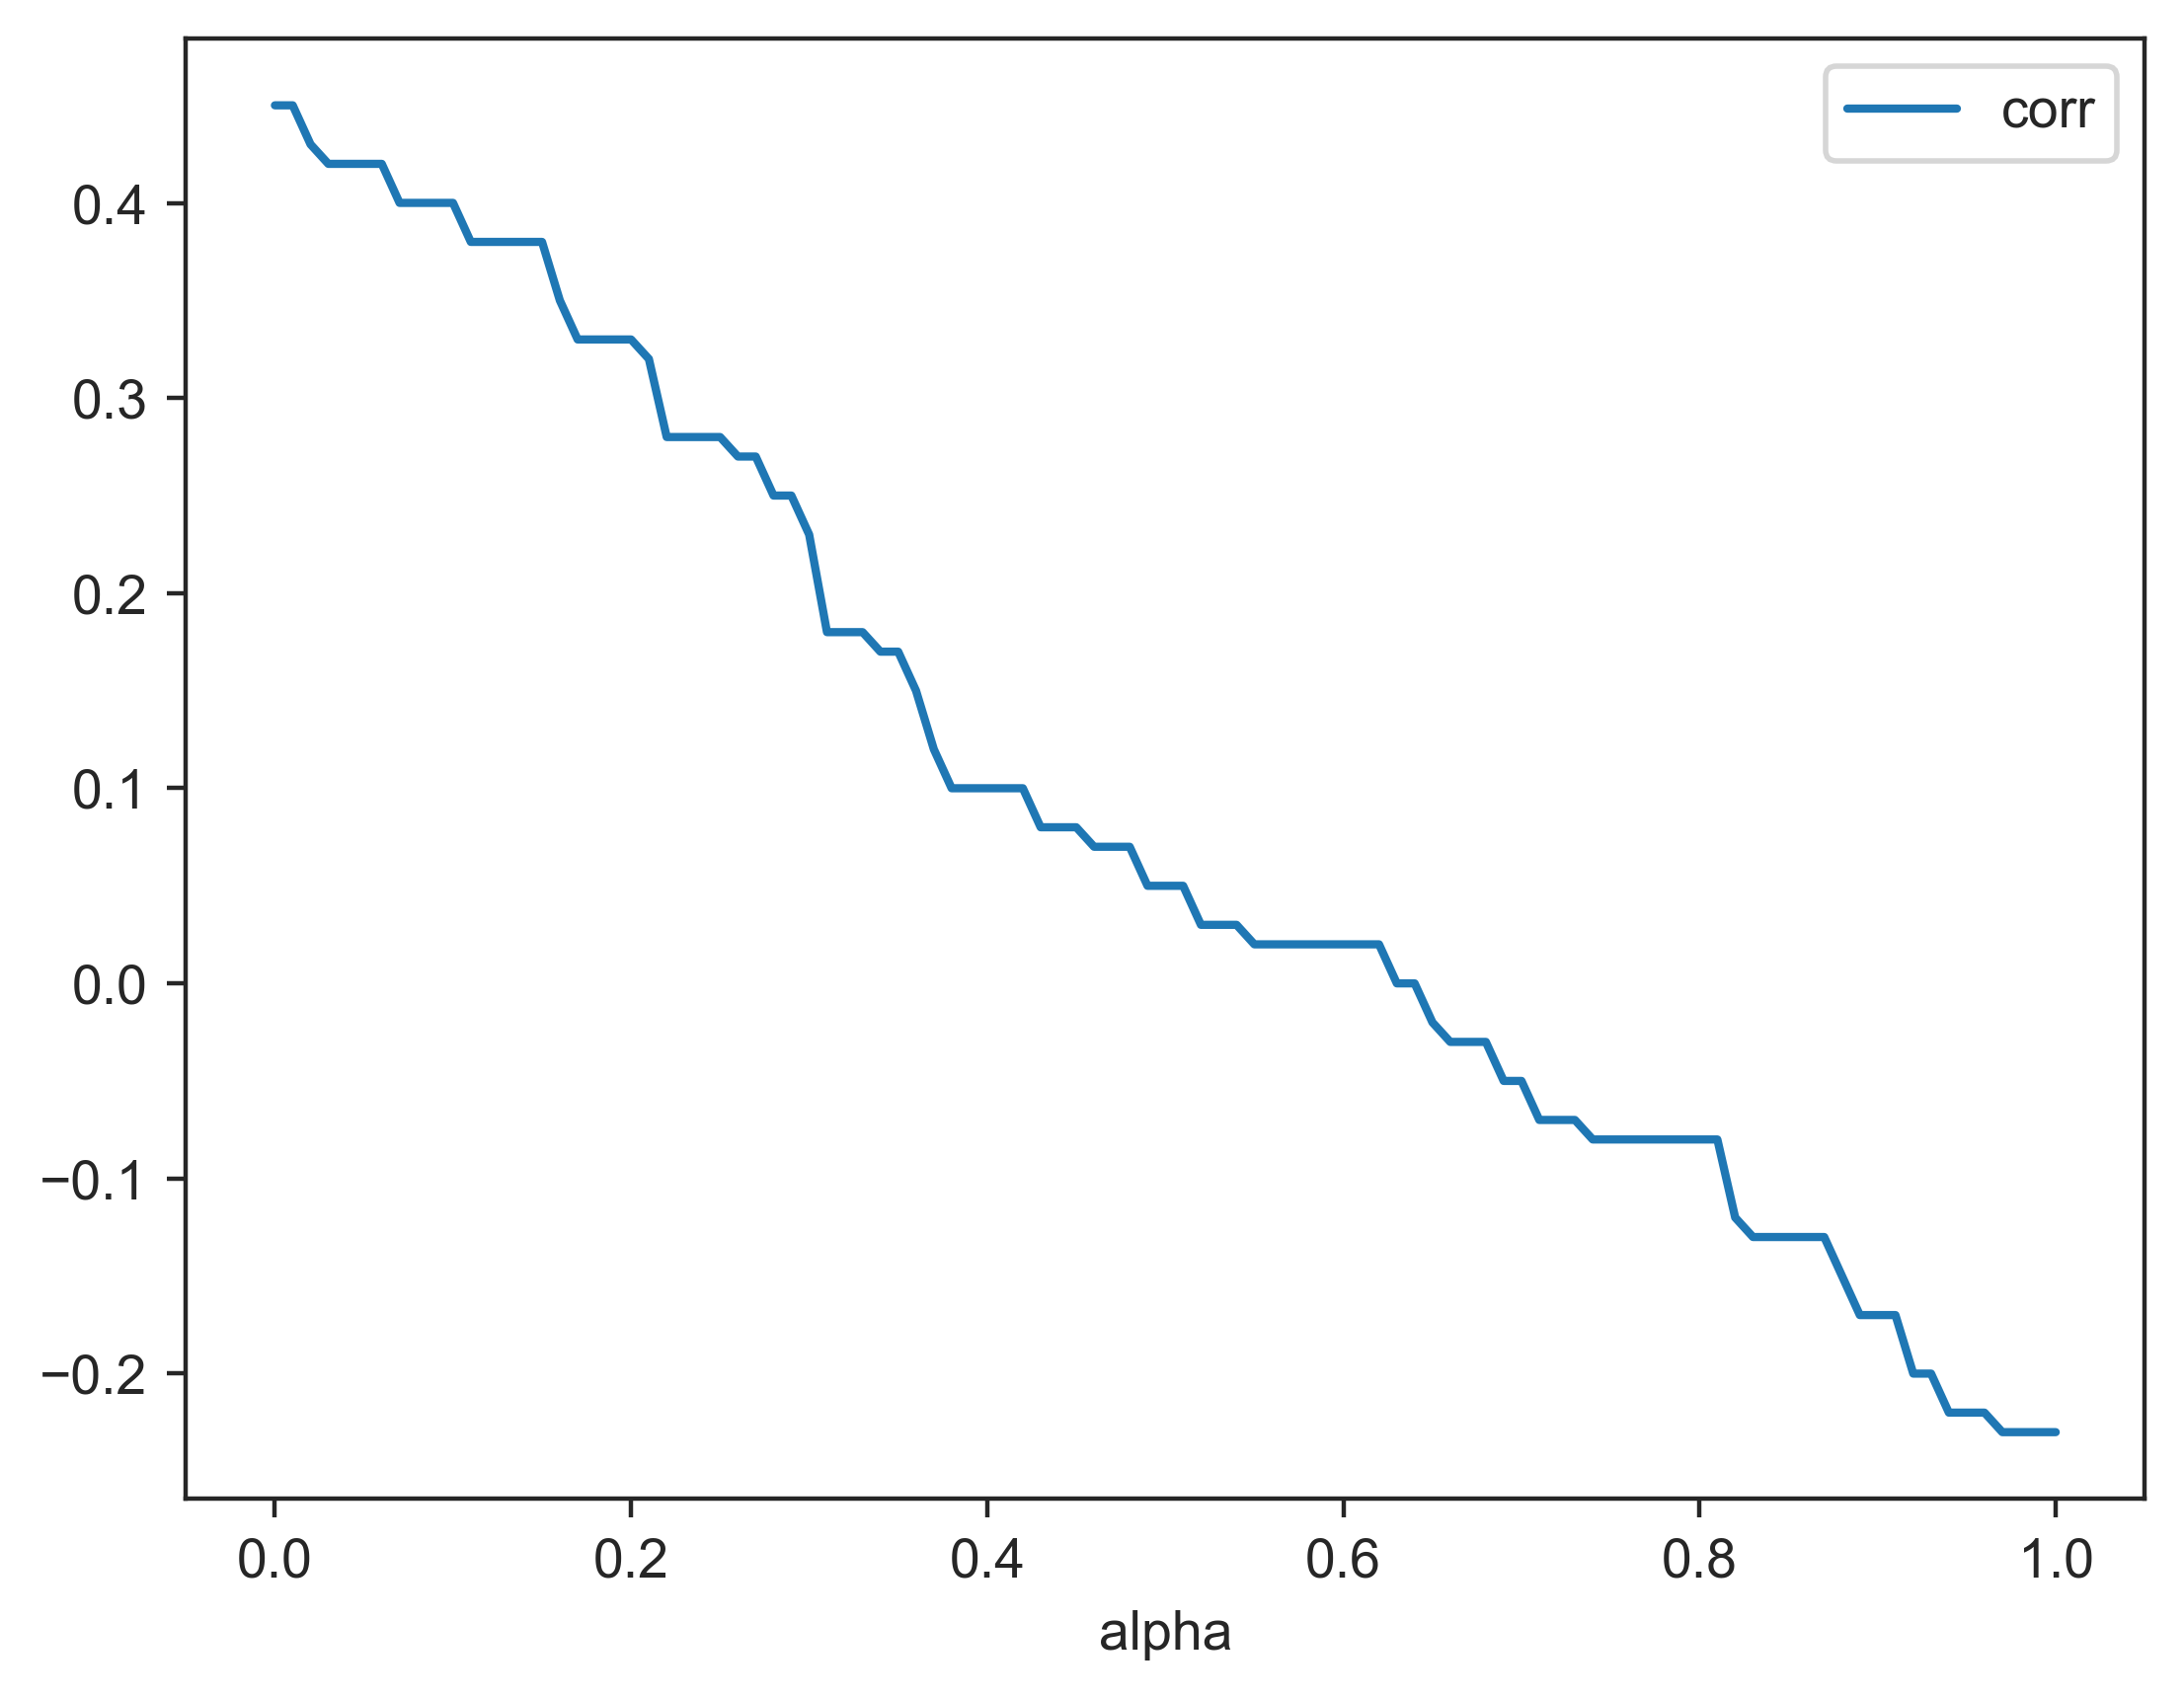

In [ ]:
this_data_DPFR_Pair.query("measure.str.contains('II')").plot(x="alpha", y="corr")

<Axes: xlabel='alpha'>

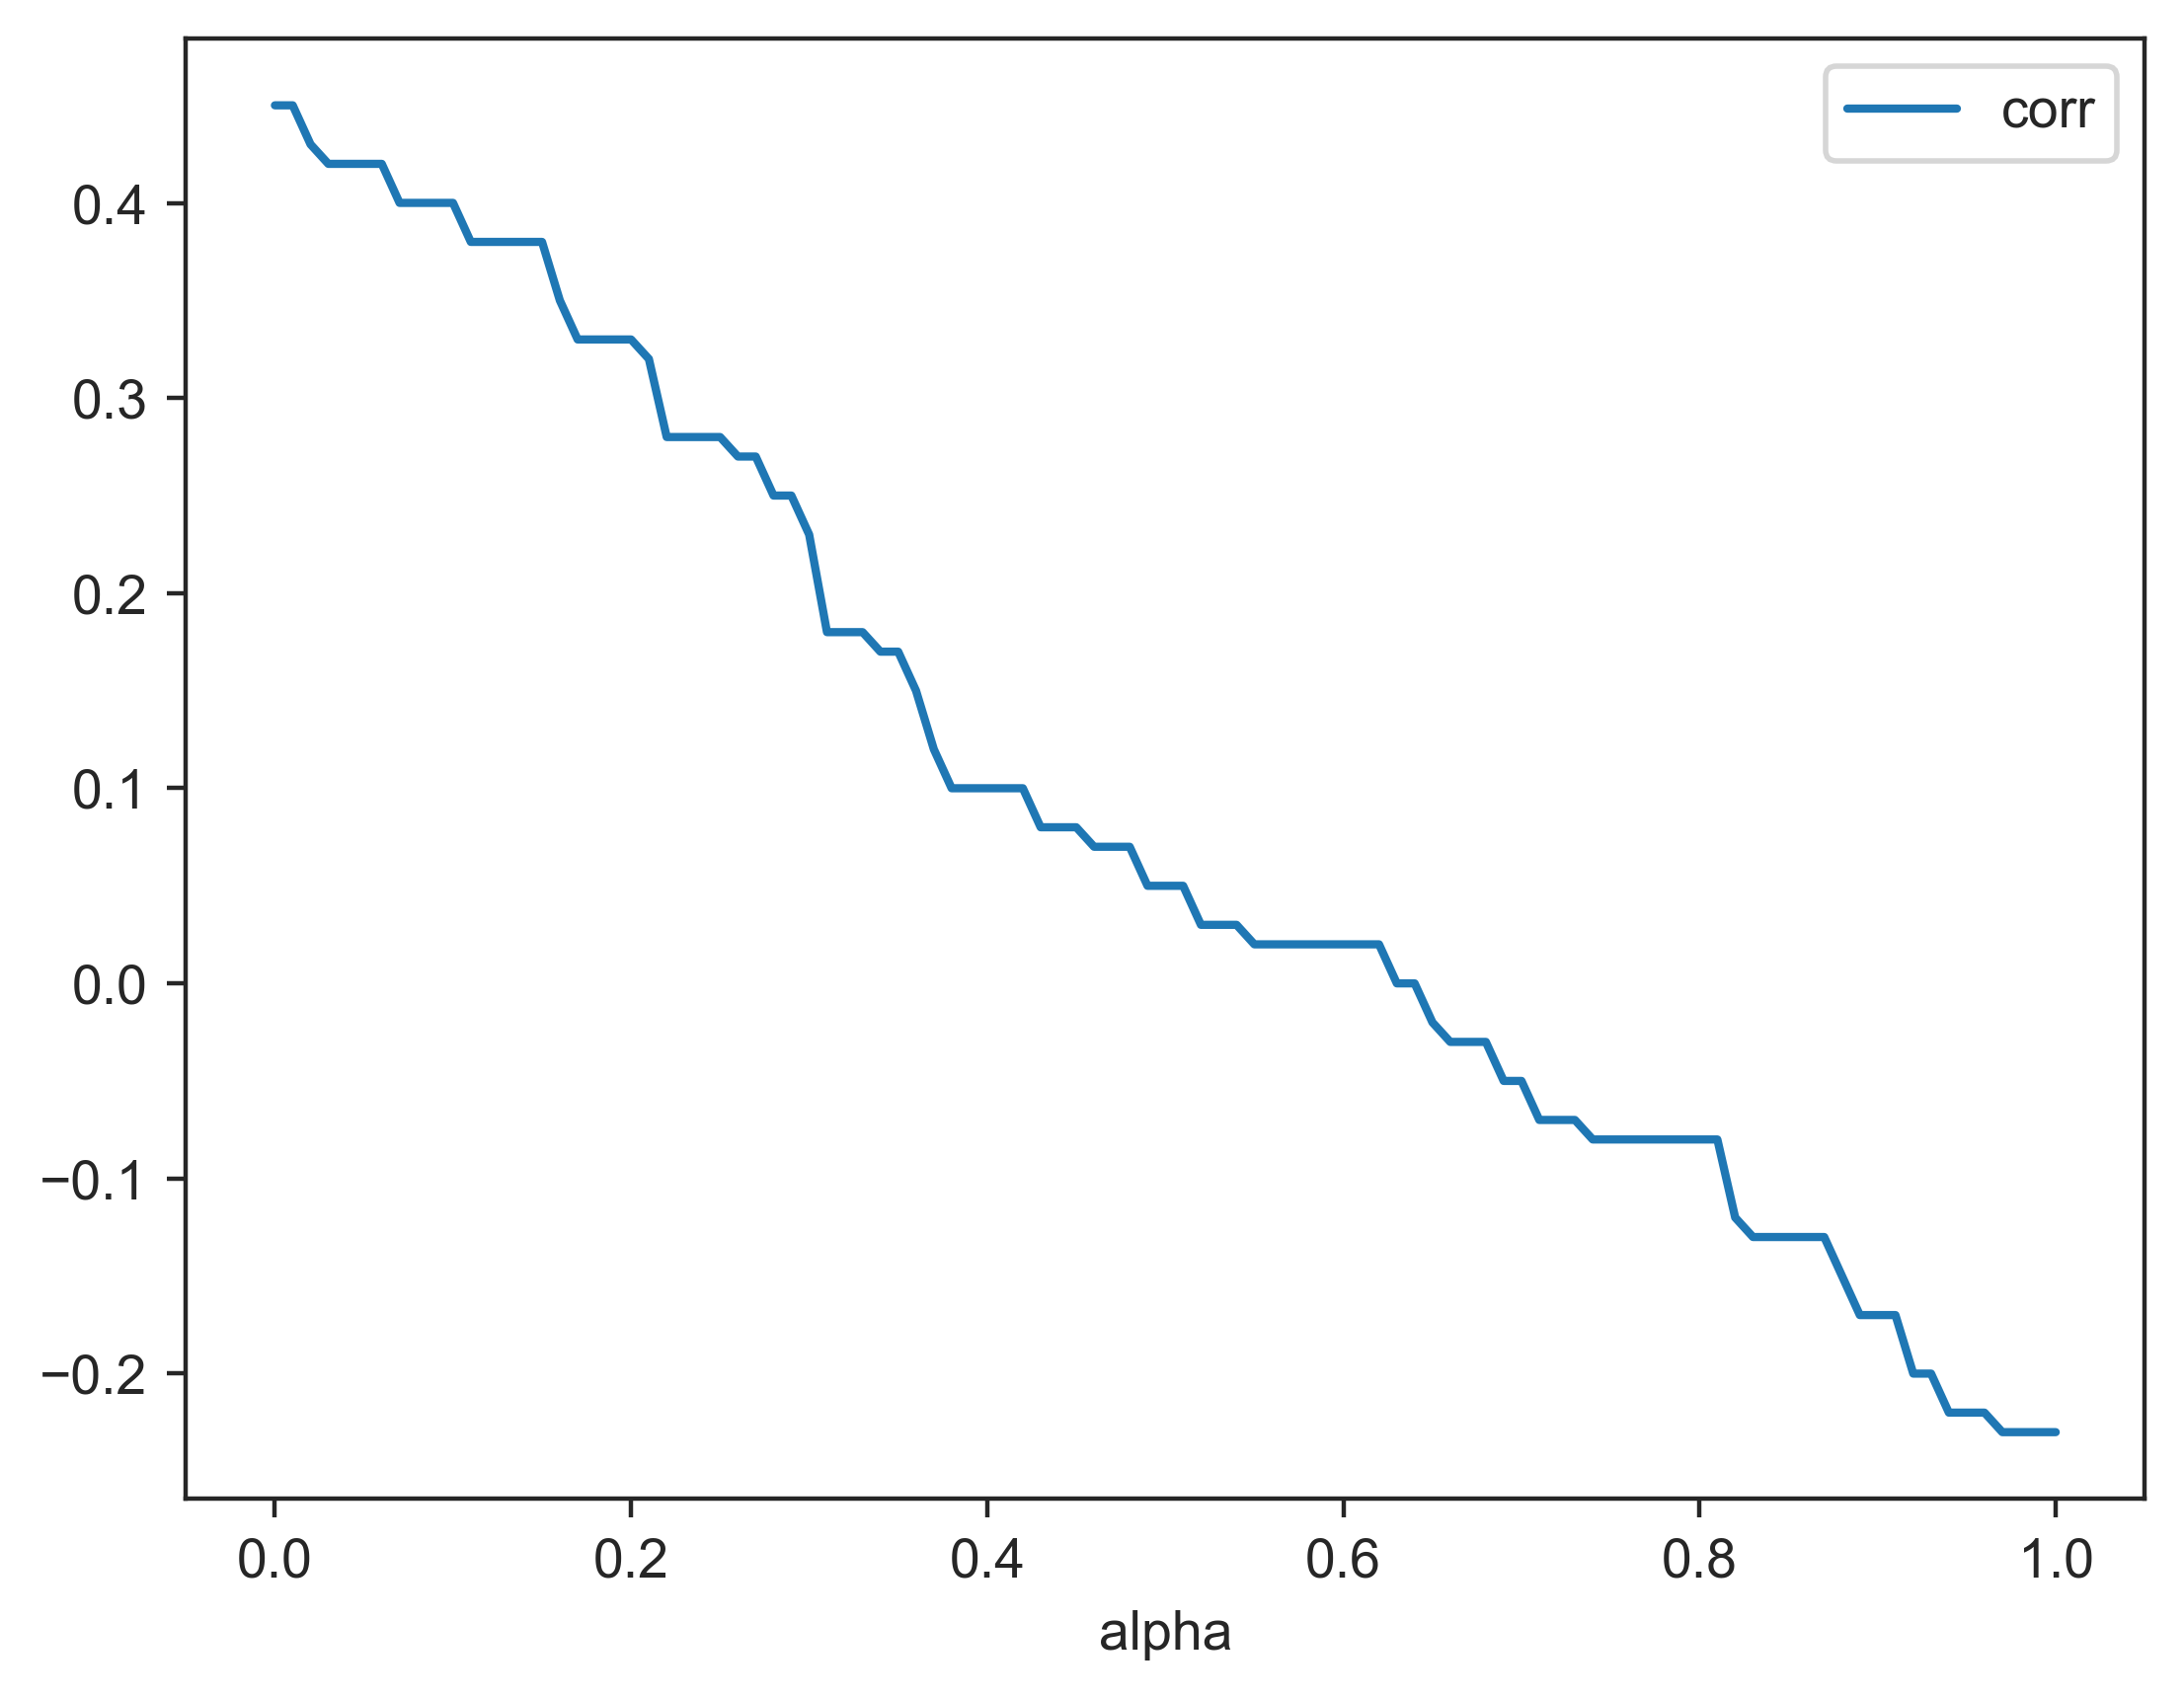

In [ ]:
this_data_DPFR_Pair.query("measure.str.contains('IAA')").plot(x="alpha", y="corr")